In [ ]:
!pip install git+https://github.com/Mayukhdeb/torch-dreams

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams.dreamer import dreamer
import torchvision.models as models

In [84]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model)

dreamer init on:  cuda


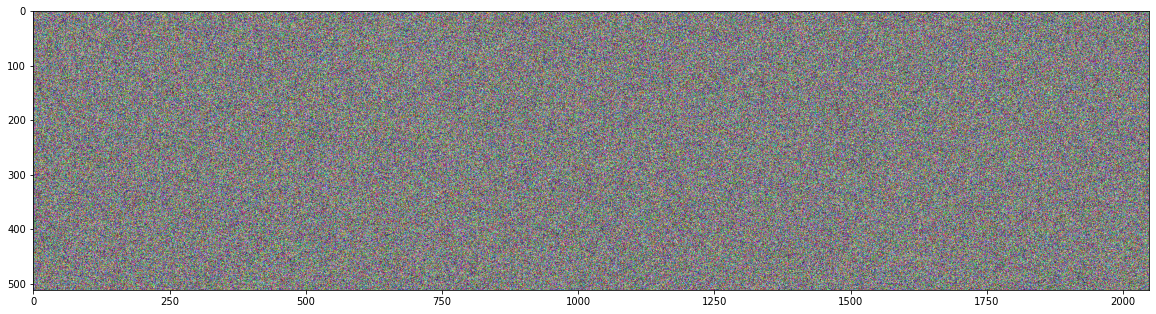

True

In [122]:
image_sample = (np.random.rand(512,512*4,3).astype(np.float32) *255).astype(np.uint8)

plt.imshow(image_sample)
plt.show()
cv2.imwrite("noise.jpg", image_sample)

In [86]:
def roll(im, shift):
    im = np.roll(im, shift, axis = 1)
    return im

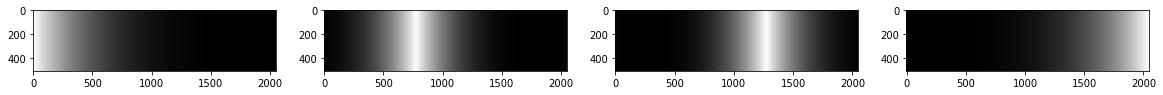

In [105]:
grad_mask =  1- np.abs(1- cv2.rotate(np.repeat(np.linspace(2, 0, 512),512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE))

grad_mask = cv2.resize(grad_mask, (512*4, 512))**3
grad_mask_l = roll(grad_mask, -250)
grad_mask_r = roll(grad_mask, 250)


grad_mask_ll =  cv2.resize(cv2.rotate(np.repeat(np.linspace(0, 1, 512)**2,512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE), (512*4, 512))**2
grad_mask_rr =  cv2.resize(cv2.rotate(np.repeat(np.linspace(1, 0, 512)**2,512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE), (512*4, 512))**2

fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (20,5))

ax.flat[0].imshow(grad_mask_ll)
ax.flat[1].imshow(grad_mask_l)
ax.flat[2].imshow(grad_mask_r)
ax.flat[3].imshow(grad_mask_rr)

In [115]:
def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[0][channel_number].mean()
        return loss
    return custom_func

alpha = make_custom_func(0, 7)
beta = make_custom_func(0, 31)
phi =  make_custom_func(0, 115)
gamma =  make_custom_func(0, 120)


In [116]:
layers_to_use = [model.Mixed_6c.branch7x7_1.conv]

config = {
    "image_path": "noise.jpg",
    "layers": layers_to_use,
    "octave_scale": 1.1,  ## 1.1
    "num_octaves": 20,  ## 14
    "iterations": 100,   ## 100
    "lr": 0.04, ## 0.05
    "max_rotation": 0.7,
    "gradient_smoothing_coeff": None,
    "gradient_smoothing_kernel_size": None,
    "grad_mask": [grad_mask_ll, grad_mask_l, grad_mask_r,grad_mask_rr],
    "custom_func":  [alpha, beta, phi, gamma],
    "grayscale": False  ## temporary fix to a bug 
}

In [ ]:
out = dreamy_boi.deep_dream_with_masks(config)

plt.imshow(out)
plt.show()

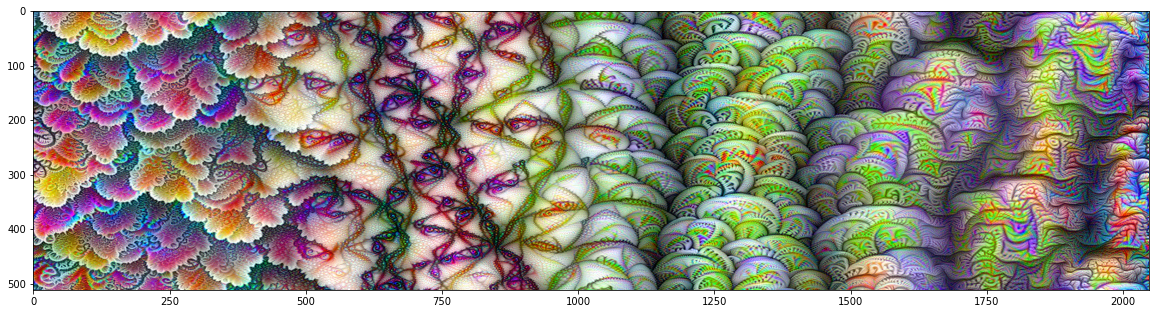

In [118]:
plt.rcParams['figure.figsize'] =20, 20

plt.imshow(out)
plt.show()

In [119]:
out_p = cv2.cvtColor((out*255), cv2.COLOR_BGR2RGB)
cv2.imwrite("out.jpg", out_p)


True